<a href="https://colab.research.google.com/github/EMockevicius/deep-learning/blob/main/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/deep_learning/style_transfer'
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/deep_learning_ld_4
biden.jpg
camo3.png
content-loss.jpg
cubism2.jpg
cubism3.jpg
cubism.jpg
forest.jpg
homelander.jpg
image_camo3_generated_at_iteration_10.png
image_camo3_generated_at_iteration_15.png
image_camo3_generated_at_iteration_20.png
image_camo3_generated_at_iteration_5.png
image.jpg
image_test_generated_at_iteration_1000.png
image_test_generated_at_iteration_100.png
image_test_generated_at_iteration_1100.png
image_test_generated_at_iteration_1200.png
image_test_generated_at_iteration_1300.png
image_test_generated_at_iteration_1400.png
image_test_generated_at_iteration_1500.png
image_test_generated_at_iteration_1600.png
image_test_generated_at_iteration_1700.png
image_test_generated_at_iteration_1800.png
image_test_generated_at_iteration_1900.png
image_test_generated_at_iteration_2000.png
image_test_generated_at

# Style Transfer

Every painter has it's own style of painting. Style could be represented by dominating colors, strokes of the brush, reoccuring patterns or objects.

Style transfer - technique of transferring frequently reoccuring features of one image to other image without affecting contents a lot.

Original paper: [https://arxiv.org/abs/1508.06576](https://arxiv.org/abs/1508.06576)

Good explanation: [https://sefiks.com/2018/07/20/artistic-style-transfer-with-deep-learning/](https://sefiks.com/2018/07/20/artistic-style-transfer-with-deep-learning/)

We already know, that convolutional neural networks layers represent various levels of features. The deeper the layer - the higher the level of features being represented. First layers may represent lines, corners, points. Intermediate layers may represent geometrical figures made from lines, corners and points. Deeper layers may represent objects made from geometrical figures.

Let's start from the main imports and setting the variables.

Note: This example works very slow on CPU so GPU is recommended.

In [ ]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # '-1' is CPU

We will use VGG19, but you are free to try some other pre-trained model.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

In [ ]:
# Image to which we will apply the style ##############
base_image_path = "paris.jpg"
#base_image_path = "sky.jpg"
#base_image_path = "forest.jpg"
#base_image_path = "biden.jpg"
#base_image_path = "trump.jpg"
#base_image_path = "homelander.jpg"


#base_image_path = "image.jpg"

# Style image from which we will take most frequently occuring features and transfer to base image #############
# For the best results make sure that style image has distinctive style features
#style_reference_image_path = "starry_night.jpg"
#style_reference_image_path = "cubism.jpg"
#style_reference_image_path = "cubism3.jpg"
style_reference_image_path = "camo3.png"

#style_reference_image_path = "test.jpg"


# To save the result
result_prefix = os.path.splitext(base_image_path)[0] + "_" + os.path.splitext(style_reference_image_path)[0] + "_generated"

# Weights of the different loss components ##############
style_weight = 0.2 # How much style to transfer
content_weight = 0.025 # How much content to transfer from base image

# Weights of the different loss components ##############
#style_weight = 0.4 # How much style to transfer
#content_weight = 0.025 # How much content to transfer from base image

# Weights of the different loss components ##############
#style_weight = 0.2 # How much style to transfer
#content_weight = 0.05 # How much content to transfer from base image

# Weights of the different loss components ##############
#style_weight = 0.6 # How much style to transfer
#content_weight = 0.1 # How much content to transfer from base image

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

Let's display the base and style images.

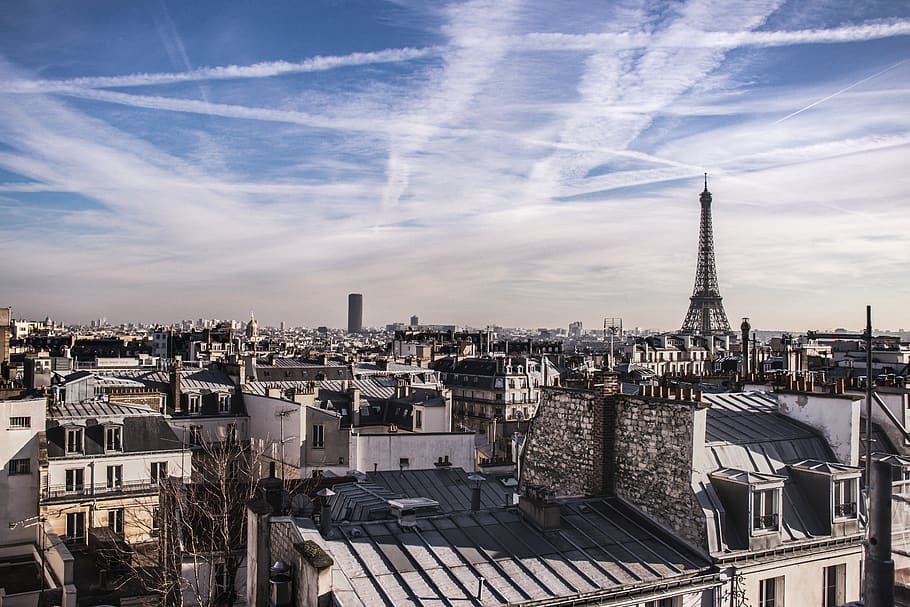

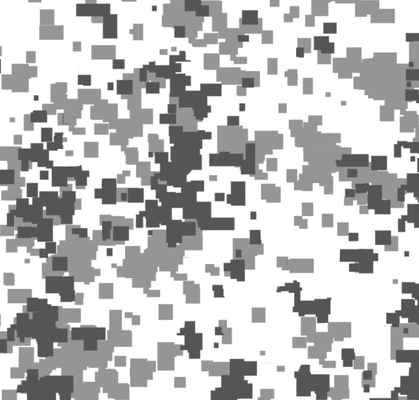

In [ ]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

Image should be pre-processed before being supplied to the model. And modified image should be "de-processed" back so it could be displayed.

In pre-processing we add one more dimension for mini-batch, then use built-in vgg19 function to shift every channel to 0 mean value.

In [ ]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    #img = vgg16.preprocess_input(img)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In "de-processing" we shift the resulting image channels values back. Change channels order back to RGB and clip values which are outside of 255 range. Finally we convert image to `uint8` to display.

In [ ]:
def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

The gram matrix is the main reason style transfering works as it is. Gram matrix is matrix multiplied by transposed itself.
![gram_matrix.jpg](attachment:gram_matrix.jpg)


In [ ]:
# The gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [ ]:
# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [ ]:
# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

Now we can build the model. Outputs will be all layers of the model.

In [ ]:
from tensorflow.keras.applications import vgg16

In [ ]:
# Build model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)
#model = vgg16.VGG16(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in outputs_dict
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Now we can select the needed layers for style and content. For vgg style model for better effect it is recommended to use layers right after shrinking (max pooling). Layer for contents was chosen the same as mentioned in paper.

In [ ]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"

Now we may define the computation of the total loss which could be simplified to this: `loss = content_weight * content_loss + style_weight * style_loss`

In [ ]:
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    return loss

Now when we have prepared all basic functions, the training could be started.

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [ ]:
# Adam optimizer is a different from one that was proposed in paper (as one in paper is not implemented in keras/tf) #######
optimizer = keras.optimizers.Adam(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1.0, decay_steps=100, decay_rate=0.96
    )
)

# We need noise image according to original paper
noise_image = np.random.randint(256, size=(1, img_nrows, img_ncols, 3)).astype(np.float32)

# Loading of base image
base_image = keras.preprocessing.image.load_img(base_image_path, target_size=(img_nrows, img_ncols))
base_image = keras.preprocessing.image.img_to_array(base_image)
base_image = np.expand_dims(base_image, axis=0)
# When generating initial combination_image instead of a random noise
# we combine noise with a base image to speed up training a bit
combination_image = (0.4 * noise_image + 0.6 * base_image)

base_image = tf.convert_to_tensor(vgg19.preprocess_input(base_image))
combination_image = tf.Variable(tf.convert_to_tensor(vgg19.preprocess_input(combination_image)))
style_reference_image = preprocess_image(style_reference_image_path)

#iterations = 2000 # initial results could be seen after 100 iterations, but for better results ~2000 iteration needed
iterations = 20 # initial results could be seen after 100 iterations, but for better results ~2000 iteration needed
for i in range(1, iterations + 1):
    # Let's caclulate loss and gradients
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    # Now apply gradients to combination_image (we change just the input image)
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 5 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 5: loss=40351703040.00
Iteration 10: loss=33074251776.00
Iteration 15: loss=27339810816.00
Iteration 20: loss=22881349632.00


Now we can check the result:

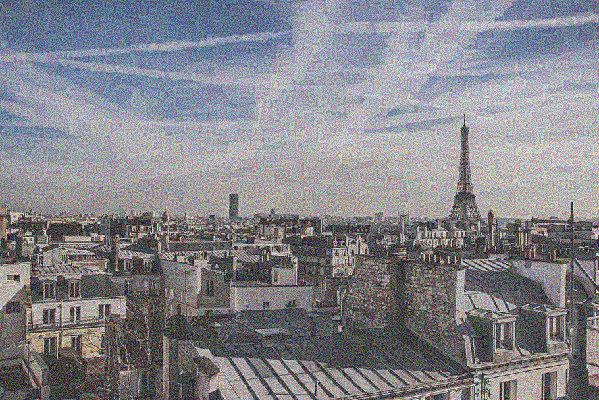

In [ ]:
display(Image(result_prefix + "_at_iteration_5.png" ))

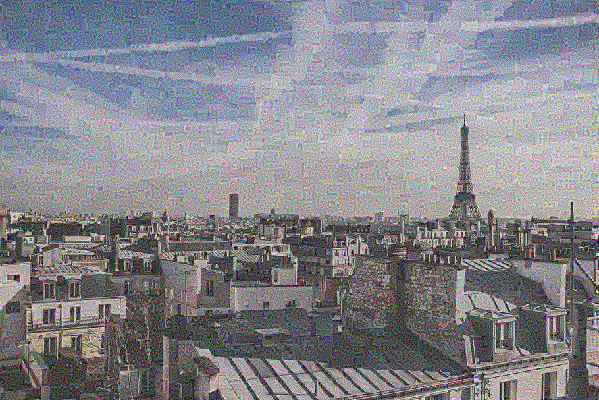

In [ ]:
display(Image(result_prefix + "_at_iteration_10.png"))

In [ ]:
display(Image(result_prefix + "_at_iteration_15.png")

In [ ]:
display(Image(result_prefix + "_at_iteration_20.png")

In [ ]:
display(Image(result_prefix + "_at_iteration_%d.png" %iterations))